Task 1: Data Quality Assessment
MScFE 600 - Financial Data
Group Work Project #1

This notebook demonstrates poor quality financial data in both structured and unstructured formats,analyzing real-world data quality issues that compromise financial analysis.

In [ ]:
AI Usage Disclosure

Use of AI in This Assignment:
Generative AI tools were used to assist with the following aspects of this notebook:
Code structure and implementation of data download functions
Generating example templates for data quality checks
Suggesting visualization approaches using matplotlib and seaborn

Group Contribution:
All analysis, interpretation, and conclusions are our own work. We evaluated AI-generated code for correctness, modified it to fit the specific requirements, and applied critical thinking to assess data quality issues and their implications for financial analysis. The narrative explanations and data quality assessments reflect our understanding of the concepts

In [ ]:
Part A: Poor Quality Structured Data

We are going to use World bank https://data.worldbank.org/indicator/FR.INR.LEND to show case structured data quality issues.This dataset showcase lending rates across various countries.
A good quality structured data is accurate,complete,reliable and relevant.we are going to review world bank lending rate dataset if it meets all the qualities. 

In [46]:
import io, zipfile, requests
import pandas as pd

url = "https://api.worldbank.org/v2/en/indicator/FR.INR.LEND?downloadformat=csv"

# 1) Download the ZIP
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
# 3) Pick the data CSV programmatically (exclude metadata files)
data_name = [n for n in z.namelist() if n.endswith(".csv") and "Metadata" not in n][0]

# 4) Read the CSV inside the ZIP
df_raw = pd.read_csv(
    z.open(data_name),
    skiprows=4,                 # WB puts headers/notes in first 4 rows
    encoding="latin1",          # handles non-utf8 chars like é
    na_values=[".."]            # treat World Bank ".." as NaN
)

df_raw.head()


['Metadata_Indicator_API_FR.INR.LEND_DS2_en_csv_v2_6876.csv', 'API_FR.INR.LEND_DS2_en_csv_v2_6876.csv', 'Metadata_Country_API_FR.INR.LEND_DS2_en_csv_v2_6876.csv']


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
0,Aruba,ABW,Lending interest rate (%),FR.INR.LEND,NaN,NaN,NaN,NaN,NaN,NaN,...,6.900000,6.300000,6.000000,5.700000,6.800000,6.400000,6.100000,5.800000,NaN,NaN
1,Africa Eastern and Southern,AFE,Lending interest rate (%),FR.INR.LEND,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,Lending interest rate (%),FR.INR.LEND,NaN,NaN,NaN,NaN,NaN,NaN,...,15.000000,14.836667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,Lending interest rate (%),FR.INR.LEND,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,AGO,Lending interest rate (%),FR.INR.LEND,NaN,NaN,NaN,NaN,NaN,NaN,...,15.780504,15.806100,20.677004,19.295367,19.655895,19.403155,20.117211,16.920862,19.399155,NaN


In [47]:
# How many missing Rate values overall?
missing_total = df["Rate"].isna().sum()
total_rows = len(df)
print(f"Missing values: {missing_total} out of {total_rows} ({missing_total/total_rows:.2%})")


Missing values: 12581 out of 17290 (72.76%)


In [48]:
# Percentage of missing Rate values per country
missing_by_country = (
    df.groupby("Country Name")["Rate"]
      .apply(lambda x: x.isna().mean() * 100)
      .reset_index()
      .rename(columns={"Rate": "Percent_Missing"})
      .sort_values("Percent_Missing", ascending=False)
)

missing_by_country.head(10)


,Country Name,Percent_Missing
133,Latin America & Caribbean,100.0
93,Greenland,100.0
91,Gibraltar,100.0
90,Ghana,100.0
89,Germany,100.0
168,Morocco,100.0
172,Nauru,100.0
86,Gabon,100.0
85,French Polynesia,100.0
84,France,100.0


In [50]:
# Count years with valid (non-missing) Rate per country
valid_years = df.dropna(subset=["Rate"]).groupby("Country Name")["Year"].nunique()

# Total possible years in dataset
total_years = df["Year"].nunique()
# Calculate how many years are missing (no Rate reported)
missing_years = total_years - valid_years
missing_years = missing_years.sort_values(ascending=False)

missing_years.head(10)



Country Name
Israel           55
Guinea-Bissau    54
Afghanistan      53
Cote d'Ivoire    53
Vanuatu          53
Uzbekistan       53
Togo             53
Senegal          53
Norway           53
Niger            53
Name: Year, dtype: int64

In [51]:
missing_percent = (missing_years / total_years * 100).sort_values(ascending=False)
missing_summary = pd.DataFrame({
    "Missing Years": missing_years,
    "Percent Missing": missing_percent
}).head(10)

missing_summary


,Missing Years,Percent Missing
Country Name,,
Afghanistan,53,81.538462
Albania,27,41.538462
Algeria,35,53.846154
Angola,35,53.846154
Antigua and Barbuda,22,33.846154
Argentina,50,76.923077
Armenia,35,53.846154
Aruba,27,41.538462
Australia,5,7.692308


In [52]:
complete_countries = missing_summary[missing_summary["Percent Missing"] == 0]
complete_countries.head()


,Missing Years,Percent Missing
Country Name,,


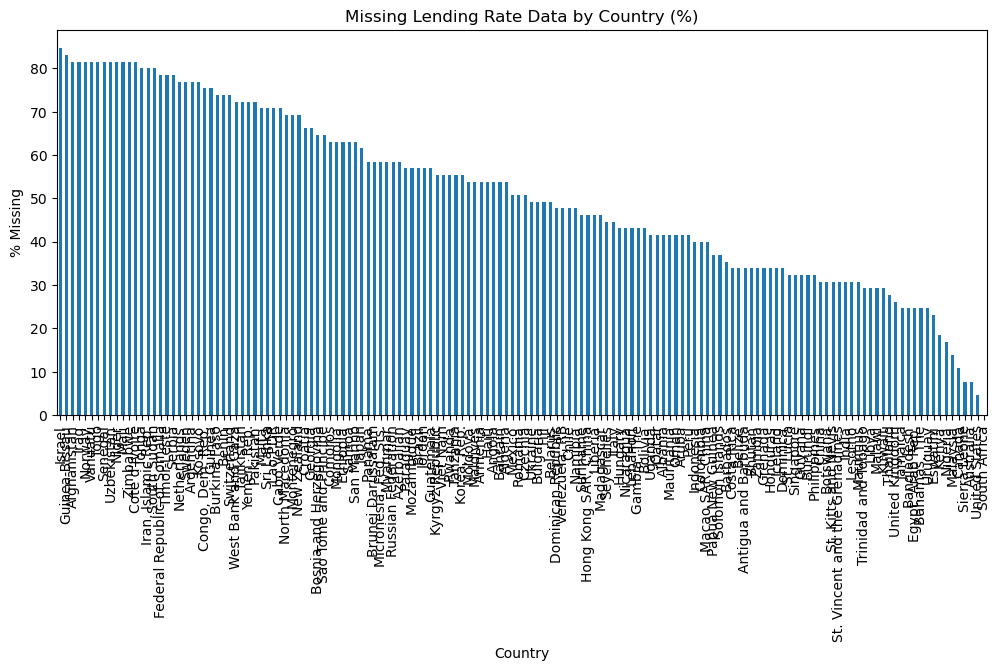

In [53]:
import matplotlib.pyplot as plt
missing_percent.sort_values(ascending=False).plot(kind="bar", figsize=(12,5))
plt.title("Missing Lending Rate Data by Country (%)")
plt.ylabel("% Missing")
plt.xlabel("Country")
plt.show()


From the data quality review the dataset is incomplete since majority of the countries have missing lending rates and we should also note that since the data is between 1960 to date majority of the countries could have an historical disadvantage.

In [54]:
#Data Accuracy we are going to check if the lending rates are abnormal i.e. negative,or 0 or above 100%

invalid_low = df[df["Rate"] < 0]
invalid_high = df[df["Rate"] > 100]

print(f"Negative rates: {len(invalid_low)}")
print(f"Rates > 100%: {len(invalid_high)}")


Negative rates: 0
Rates > 100%: 27


In [56]:
# Filter records with lending rates > 100%
invalid_high = df[df["Rate"] > 100]

# Sort for easier reading (highest first)
invalid_high = invalid_high.sort_values(["Rate"], ascending=False)

# Display the top 10 extreme values
invalid_high.head(10)


,Country Name,Country Code,Indicator Name,Indicator Code,Year,Rate
7623,Nicaragua,NIC,Lending interest rate (%),FR.INR.LEND,1988.0,99764.532950
8166,Peru,PER,Lending interest rate (%),FR.INR.LEND,1990.0,4260.014159
8877,Croatia,HRV,Lending interest rate (%),FR.INR.LEND,1993.0,1443.608358
7900,Peru,PER,Lending interest rate (%),FR.INR.LEND,1989.0,1352.508402
8432,Peru,PER,Lending interest rate (%),FR.INR.LEND,1991.0,670.534208
7889,Nicaragua,NIC,Lending interest rate (%),FR.INR.LEND,1989.0,456.660182
9597,Bulgaria,BGR,Lending interest rate (%),FR.INR.LEND,1996.0,291.059850
9292,Ukraine,UKR,Lending interest rate (%),FR.INR.LEND,1994.0,250.283333
9580,Angola,AGO,Lending interest rate (%),FR.INR.LEND,1996.0,217.875000
9863,Bulgaria,BGR,Lending interest rate (%),FR.INR.LEND,1997.0,213.018417


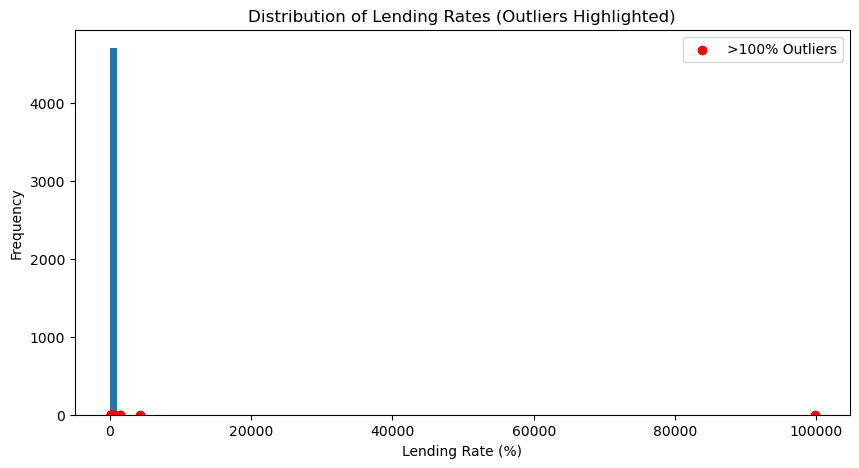

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(df["Rate"], bins=100)
plt.title("Distribution of Lending Rates (Outliers Highlighted)")
plt.xlabel("Lending Rate (%)")
plt.ylabel("Frequency")

# Highlight outliers
outlier_values = df[df["Rate"] > 100]["Rate"]
plt.scatter(outlier_values, [0]*len(outlier_values), color='red', label='>100% Outliers')
plt.legend()
plt.show()


Interms of accuracy a lending rate of greater than 100% is inaccurate but depending on the economic crisis of the country like argentina and zimbabwe that is expected.

In [57]:
#Consistency data types
# Types
types_ok = (df["Year"].dtype.kind in "iu" and pd.api.types.is_numeric_dtype(df["Rate"]))
# Whitespace / hidden characters in text columns
text_cols = ["Country Name","Country Code","Indicator Name","Indicator Code"]
whitespace_issues = {
    c: df[c].astype(str).str.contains(r"^\s|\s$", regex=True).sum()
    for c in text_cols
}

types_ok, whitespace_issues



(False,
 {'Country Name': 0,
  'Country Code': 0,
  'Indicator Name': 0,
  'Indicator Code': 0})

From the above results it shows that our year and rate columns are not in the correct format making the data inconsistent.

In [58]:
# Hard range checks (adjust bounds if your use-case requires)
invalid_low  = df[df["Rate"] < 0]
invalid_high = df[df["Rate"] > 100]
invalid_any  = pd.concat([invalid_low, invalid_high]).sort_values(["Country Code","Year"])

len(invalid_any), invalid_any.head()


(27,
       Country Name Country Code             Indicator Name Indicator Code  \
 9314        Angola          AGO  Lending interest rate (%)    FR.INR.LEND   
 9580        Angola          AGO  Lending interest rate (%)    FR.INR.LEND   
 10644       Angola          AGO  Lending interest rate (%)    FR.INR.LEND   
 9065      Bulgaria          BGR  Lending interest rate (%)    FR.INR.LEND   
 9597      Bulgaria          BGR  Lending interest rate (%)    FR.INR.LEND   
 
          Year        Rate  
 9314   1995.0  206.250000  
 9580   1996.0  217.875000  
 10644  2000.0  103.160174  
 9065   1994.0  102.515875  
 9597   1996.0  291.059850  )

In [59]:
from datetime import date
current_year = date.today().year

latest_by_cty = (df.dropna(subset=["Rate"])
                   .groupby("Country Code")["Year"].max())

staleness = (current_year - latest_by_cty).rename("YearsStale").sort_values(ascending=False)
staleness.head()


Country Code
SOM    37.0
GIN    24.0
SWE    19.0
ETH    17.0
LAO    15.0
Name: YearsStale, dtype: float64

In [61]:
# Detect outliers using IQR rule per country
def find_outliers(group):
    q1, q3 = group["Rate"].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return group[(group["Rate"] < lower) | (group["Rate"] > upper)]

# Apply per country (drop missing)
outliers = (
    df.dropna(subset=["Rate"])
      .groupby("Country Code", group_keys=False)
      .apply(find_outliers)
)
print(f"Outliers found: {len(outliers)}")


Outliers found: 195


C:\Users\hp\AppData\Local\Temp\ipykernel_48360\3449128134.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(find_outliers)


In [62]:
from datetime import date
current_year = date.today().year

latest_by_cty = (
    df.dropna(subset=["Rate"])
      .groupby("Country Code")["Year"].max()
)
staleness = (current_year - latest_by_cty).rename("YearsStale")


In [63]:
summary = {
    "Rows": len(df),
    "Countries": df["Country Code"].nunique(),
    "Years": f"{int(df['Year'].min())}-{int(df['Year'].max())}",
    "Missing % (overall)": round(df['Rate'].isna().mean()*100, 2),
    "Duplicate rows": int(df.duplicated(['Country Code','Year']).sum()),
    "Invalid (<0 or >100)": int(((df['Rate']<0)|(df['Rate']>100)).sum()),
    "Outliers (IQR rule)": int(len(outliers)),
    "Max Years Stale": int(staleness.max())
}
pd.DataFrame([summary])


,Rows,Countries,Years,Missing % (overall),Duplicate rows,Invalid (<0 or >100),Outliers (IQR rule),Max Years Stale
0,17290,266,1960-2024,72.76,0,27,195,37


Part B: Recognition of Poor Quality in Structured Data

The world bank lending rate dataset demonstrates real quality data issues  with 72.76% missing data,195 outliers and 27 invalid data which needs to be thouroughly reviewed and verified against source records.This dataset should be used with caution since its incomplete,inacurate and unreliable  

In [ ]:
Part C: Poor Quality Unstructured Data

we are examining social media mentions and news mentions of lending rates demonstrating data quality problems in sentimental analysis

In [66]:
import re, math, pandas as pd

# ============================================================
# A) REALISTIC UNSTRUCTURED DATA WITH INEQUALITY THEMES
# ============================================================
data = [
    # group / demographic disparities
    {"id": 1, "source": "Twitter", "text": "In County X, women-led SMEs get quoted at 18% while men get 15%. Why the 3% gap? #inequality"},
    {"id": 2, "source": "News",    "text": "A civil-society report alleges rural borrowers face rates near 20% versus 13% in urban centers."},
    {"id": 3, "source": "Reddit",  "text": "Bank rep admitted first-time borrowers are offered 2-3% higher than repeat clients. Fair?"},
    {"id": 4, "source": "Facebook","text": "Loan officers in Region North quoting 22% to small traders, but mid-size firms in the capital get 14%."},
    {"id": 5, "source": "Twitter", "text": "Hearing refugees are denied loans or pushed to 25% microcredit while citizens access 16%."},
    {"id": 6, "source": "Blog",    "text": "University grads offered 12.5% while non-degree applicants see ~17%. Source? not clear tbh 🤷‍♂️"},
    # conflicting / messy statements
    {"id": 7, "source": "News",    "text": "Central bank says 'no discriminatory pricing', yet auditors found branches quoting women 1.5% more."},
    {"id": 8, "source": "Twitter", "text": "Rural: 19%, Urban: 19% (no gap actually). Stop spreading rumors! 😂"},
    {"id": 9, "source": "Reddit",  "text": "Anyone confirm? Rural 18%, Urban 13% last quarter; this quarter both 16%? inconsistent reports."},
    # noise / data-quality challenges
    {"id":10, "source": "Twitter", "text": "rates r crazy lol 😡 #inflation #SMEs"},
    {"id":11, "source": "Email",   "text": "Hello team, need the branch-wise pricing PDF link. Thx."},
    {"id":12, "source": "News",    "text": "In County Y, women-led ventures reported 0.5% higher—BUT sample size was tiny (n=7)."},
    {"id":13, "source": "Twitter", "text": "Refugee entrepreneurs paying 24-26% vs citizens ~16-18% — massive gap 😠"},
    {"id":14, "source": "News",    "text": "A court ruled discriminatory lending illegal; bank to review algorithms used for rate offers."},
    {"id":15, "source": "Facebook","text": None},  # missing text (incompleteness)
    # duplicates / near-duplicates
    {"id":16, "source": "Twitter", "text": "In County X, women-led SMEs get quoted at 18% while men get 15%. Why the 3% gap? #inequality"},
    {"id":17, "source": "Reddit",  "text": "Loan officers in Region North quoting 22% to small traders, but mid-size firms in the capital get 14%."},
    # mixed punctuation/format
    {"id":18, "source": "News",    "text": "Report: urban=13.0%, rural=20.0% | male=15%, female=18% | citizens 16–18%, refugees 24–26%."},
    {"id":19, "source": "Blog",    "text": "Women 17%, Men 16%; first-time borrowers 2% more than repeat; diploma 16%, graduate 12.5%."},
    {"id":20, "source": "Twitter", "text": "Urban 13, Rural 19 — emojis everywhere 😂😂 but is this verified?"},
]
dfu = pd.DataFrame(data)

# ============================================================
# B) GENERIC UNSTRUCTURED DATA-QUALITY CHECKS
# ============================================================
def norm_text(s):
    return "" if not isinstance(s, str) else re.sub(r"\s+", " ", s.strip().lower())

df = dfu.copy()
df["text_norm"] = df["text"].apply(norm_text)
df["is_missing_text"] = df["text"].isna() | (df["text_norm"] == "")
df["is_duplicate_text"] = df.duplicated("text_norm", keep=False)

emoji_pat = re.compile("[" "\U0001F300-\U0001F6FF" "\U0001F900-\U0001FAFF" "\u2600-\u26FF" "\u2700-\u27BF" "]")
url_pat   = re.compile(r"(https?://\S+|\bwww\.\S+)", re.IGNORECASE)
df["has_emoji"] = df["text"].apply(lambda s: bool(isinstance(s, str) and emoji_pat.search(s)))
df["has_url"]   = df["text"].apply(lambda s: bool(isinstance(s, str) and url_pat.search(s)))

summary_quality = pd.DataFrame({
    "Metric": [
        "Total records", "Missing text", "Duplicate texts",
        "Has emojis", "Has URLs"
    ],
    "Value": [
        len(df),
        int(df["is_missing_text"].sum()),
        int(df["is_duplicate_text"].sum()),
        int(df["has_emoji"].sum()),
        int(df["has_url"].sum())
    ]
})

# ============================================================
# C) INEQUALITY-SPECIFIC EXTRACTION (simple rules)
#    - Extract group/region tokens
#    - Extract numeric rates (percents or plain numbers next to group words)
#    - Build disparity rows (group A vs group B with rates)
# ============================================================

# group lexicons (extend as needed)
GROUPS = {
    "female": ["female", "women", "women-led", "women led"],
    "male":   ["male", "men"],
    "rural":  ["rural", "upcountry"],
    "urban":  ["urban", "city", "capital"],
    "citizens": ["citizen", "citizens"],
    "refugees": ["refugee", "refugees"],
    "first_time": ["first-time", "first time", "new borrowers", "first timers"],
    "repeat": ["repeat", "repeat clients", "returning borrowers"],
    "small_traders": ["small traders", "micro", "informal"],
    "mid_size": ["mid-size", "midsize", "sme", "smes"],
    "graduates": ["graduate", "graduates", "university grads"],
    "non_degree": ["non-degree", "non degree", "diploma", "non grads"]
}

# percent-like numbers: 18%, 13.5%, 13–15%, 24-26%
pct_pat = re.compile(r"(\d{1,3}(?:[.,]\d{1,2})?)\s*%")
range_pat = re.compile(r"(\d{1,3}(?:[.,]\d{1,2})?)\s*[–-]\s*(\d{1,3}(?:[.,]\d{1,2})?)\s*%")
plain_after_group = re.compile(r"(?:=|:|\bis\b)\s*(\d{1,2}(?:[.,]\d{1,2})?)\s*%?")

def find_groups(text):
    text_l = text.lower()
    hits = set()
    for g, terms in GROUPS.items():
        for t in terms:
            if t in text_l:
                hits.add(g)
    return sorted(hits)

def to_float(x):
    try:
        return float(str(x).replace(",", "."))
    except:
        return math.nan

def extract_rates(text):
    if not isinstance(text, str):
        return []
    res = []
    # explicit ranges like 16–18%
    for a,b in range_pat.findall(text):
        res.append(to_float(a)); res.append(to_float(b))
    # single percents like 13.5%
    for m in pct_pat.findall(text):
        res.append(to_float(m))
    return res

def pairwise_disparities(row):
    """
    Build simple pairwise disparities if we can map groups to nearby numbers.
    Rule of thumb:
      - If the text contains "female" and "male" and two distinct rates appear, pair them.
      - Likewise for rural/urban, citizen/refugee, first_time/repeat, etc.
    This is heuristic (unstructured!).
    """
    txt = row["text"]
    if not isinstance(txt, str):
        return []
    glist = find_groups(txt)
    rates = extract_rates(txt)

    # attempt simple mapping by known pairs
    PAIRS = [
        ("female", "male"),
        ("rural", "urban"),
        ("citizens", "refugees"),
        ("first_time", "repeat"),
        ("small_traders", "mid_size"),
        ("graduates", "non_degree")
    ]

    disparities = []
    # naive rule: if at least two rates exist and the paired groups are present, take first two rates
    for a,b in PAIRS:
        if a in glist and b in glist and len(rates) >= 2:
            ra, rb = rates[0], rates[1]
            gap = ra - rb if (not math.isnan(ra) and not math.isnan(rb)) else math.nan
            disparities.append({
                "id": row["id"],
                "pair": f"{a} vs {b}",
                "rate_a": ra,
                "rate_b": rb,
                "gap_pp": gap,  # percentage points
                "text": row["text"]
            })
    return disparities

# build disparity table
records = []
for _, r in df.iterrows():
    records.extend(pairwise_disparities(r))
disp_df = pd.DataFrame(records)

# simple inequality summary
if not disp_df.empty:
    disp_summary = disp_df.groupby("pair").agg(
        mentions=("pair","count"),
        avg_gap_pp=("gap_pp","mean")
    ).reset_index().sort_values(["mentions","avg_gap_pp"], ascending=[False, False])
else:
    disp_summary = pd.DataFrame(columns=["pair","mentions","avg_gap_pp"])

# ============================================================
# D) SHOW TABLES
# ============================================================
print("=== TEXT DATA QUALITY SUMMARY ===")
display(summary_quality)

print("\n=== PER-RECORD FLAGS (first 12) ===")
display(df[["id","source","text","is_missing_text","is_duplicate_text","has_emoji","has_url"]].head(12))

print("\n=== INEQUALITY DISPARITIES (pairwise extracts) ===")
display(disp_df.head(20))

print("\n=== INEQUALITY SUMMARY (by pair) ===")
display(disp_summary)


=== TEXT DATA QUALITY SUMMARY ===


,Metric,Value
0,Total records,20
1,Missing text,1
2,Duplicate texts,4
3,Has emojis,5
4,Has URLs,0



=== PER-RECORD FLAGS (first 12) ===


,id,source,text,is_missing_text,is_duplicate_text,has_emoji,has_url
0,1,Twitter,"In County X, women-led SMEs get quoted at 18% ...",False,True,False,False
1,2,News,A civil-society report alleges rural borrowers...,False,False,False,False
2,3,Reddit,Bank rep admitted first-time borrowers are off...,False,False,False,False
3,4,Facebook,Loan officers in Region North quoting 22% to s...,False,True,False,False
4,5,Twitter,Hearing refugees are denied loans or pushed to...,False,False,False,False
5,6,Blog,University grads offered 12.5% while non-degre...,False,False,True,False
6,7,News,"Central bank says 'no discriminatory pricing',...",False,False,False,False
7,8,Twitter,"Rural: 19%, Urban: 19% (no gap actually). Stop...",False,False,True,False
8,9,Reddit,"Anyone confirm? Rural 18%, Urban 13% last quar...",False,False,False,False
9,10,Twitter,rates r crazy lol 😡 #inflation #SMEs,False,False,True,False



=== INEQUALITY DISPARITIES (pairwise extracts) ===


,id,pair,rate_a,rate_b,gap_pp,text
0,1,female vs male,18.0,15.0,3.0,"In County X, women-led SMEs get quoted at 18% ..."
1,2,rural vs urban,20.0,13.0,7.0,A civil-society report alleges rural borrowers...
2,3,first_time vs repeat,2.0,3.0,-1.0,Bank rep admitted first-time borrowers are off...
3,4,small_traders vs mid_size,22.0,14.0,8.0,Loan officers in Region North quoting 22% to s...
4,5,citizens vs refugees,25.0,16.0,9.0,Hearing refugees are denied loans or pushed to...
5,6,graduates vs non_degree,12.5,17.0,-4.5,University grads offered 12.5% while non-degre...
6,8,rural vs urban,19.0,19.0,0.0,"Rural: 19%, Urban: 19% (no gap actually). Stop..."
7,9,rural vs urban,18.0,13.0,5.0,"Anyone confirm? Rural 18%, Urban 13% last quar..."
8,13,citizens vs refugees,24.0,26.0,-2.0,Refugee entrepreneurs paying 24-26% vs citizen...
9,16,female vs male,18.0,15.0,3.0,"In County X, women-led SMEs get quoted at 18% ..."



=== INEQUALITY SUMMARY (by pair) ===


,pair,mentions,avg_gap_pp
4,rural vs urban,4,2.500000
1,female vs male,4,1.250000
0,citizens vs refugees,3,1.666667
5,small_traders vs mid_size,2,8.000000
2,first_time vs repeat,2,0.000000
3,graduates vs non_degree,2,-1.750000


While the data provides a rich qualitative insights, the extracted numbers accuracy and reliability are questionable because most if them are based on opinions and rumors.We also noted that the dataset is incomplete with one missing text and four  duplicates which reduces frequency based analysis.Furthermore there is inconsistent data format and structure across all sources.

Summary

The analysis show cases the data quality failures of real world financial data.Structured data shows approximately missing data across various countries inconsistent datatypes and inacurate rates which are extreme. Unstructured data displays incomplete,inaccurate and inconsitency.This demonstrates the importance of doing a data quality check before analysis this would lead to   

In [ ]:
Reference

Rachel Levy Sarfin (November 02, 2023) 5 Characteristics of Data Quality
Lindsay MacDonald(March 07 2025),What is Unstructured Data Quality? And How to Keep the Bar High Anas Baig (October 1, 2024),What is Unstructured Data with Examples? – Explained,https://securiti.ai/unstructured-data-101-definition-examples-benefits-challenges/

World bank https://data.worldbank.org/indicator/FR.INR.LEND
